<a href="https://colab.research.google.com/github/Trotamundoswon/final-project-trotamundos_won/blob/main/Proyecto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PASO 01: IMPORTAR LAS LIBRERIAS A USAR

In [14]:
 # =============================================
# Paso 1: Importar librerías y preparar entorno
# Proyecto: Predicción de series financieras con Transformer (TF/Keras)
# =============================================

# Si aún no tienes los paquetes, instálalos con:
# pip install tensorflow yfinance scikit-learn pandas numpy matplotlib

import os
import sys
import math
import random
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple, List

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ------------------------------
# Reproducibilidad básica
# ------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# ------------------------------
# Configuración de GPU (opcional)
# ------------------------------
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detectadas: {len(gpus)}")
    else:
        print("No se detectó GPU: se usará CPU.")
except Exception as e:
    warnings.warn(f"No se pudo configurar la GPU: {e}")

print("Versiones -> numpy:", np.__version__,
      "pandas:", pd.__version__,
      "tensorflow:", tf.__version__)


GPUs detectadas: 1
Versiones -> numpy: 2.0.2 pandas: 2.2.2 tensorflow: 2.19.0


PASO 02: DEFINIMOS DEL MODELO A USAR

In [17]:
# =============================================
# Paso 2 Mejorado: Definir modelo Transformer (≥50 capas efectivas)
# Proyecto: Predicción financiera con Transformer (TF/Keras)
# =============================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ------------------------------
# Bloque Transformer Encoder
# ------------------------------
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1, name_prefix="encoder"):
    # Normalización + MultiHead Attention
    x = layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_ln1")(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout,
        name=f"{name_prefix}_mha"
    )(x, x)
    x = layers.Dropout(dropout, name=f"{name_prefix}_drop1")(x)
    res = x + inputs

    # Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6, name=f"{name_prefix}_ln2")(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu", name=f"{name_prefix}_ff1")(x)
    x = layers.Dropout(dropout, name=f"{name_prefix}_drop2")(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, name=f"{name_prefix}_ff2")(x)
    return x + res

# ------------------------------
# Construcción del modelo
# ------------------------------
def build_transformer_model(
    input_shape,
    head_size=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=25,   # Cada bloque añade 2 capas efectivas => ~50 capas
    mlp_units=[128, 64],
    dropout=0.1,
    mlp_dropout=0.2,
    task="regression"
):
    inputs = keras.Input(shape=input_shape, name="Input")
    x = inputs

    # Bloques Transformer
    for i in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, name_prefix=f"block{i+1}")

    # Pooling global
    x = layers.GlobalAveragePooling1D(name="GlobalAvgPool")(x)

    # MLP final
    for i, dim in enumerate(mlp_units):
        x = layers.Dense(dim, activation="relu", name=f"mlp_dense{i+1}")(x)
        x = layers.Dropout(mlp_dropout, name=f"mlp_drop{i+1}")(x)

    # Capa de salida adaptable
    if task == "regression":
        outputs = layers.Dense(1, activation="linear", name="Output")(x)
    elif task == "classification":
        outputs = layers.Dense(2, activation="softmax", name="Output")(x)
    else:
        raise ValueError("task debe ser 'regression' o 'classification'")

    return keras.Model(inputs, outputs, name="Transformer_TS_50L")

# ------------------------------
# Creación del modelo (solo después de Paso 3)
# ------------------------------
try:
    input_shape = X_train.shape[1:]   # (timesteps, features)
    model = build_transformer_model(
        input_shape=input_shape,
        head_size=64,
        num_heads=4,
        ff_dim=128,
        num_transformer_blocks=25,
        mlp_units=[256, 128],
        dropout=0.1,
        mlp_dropout=0.3,
        task="regression"
    )

    model.compile(
        loss="mse",
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["mae"]
    )

    model.summary()

except NameError:
    print("ℹ️ Aún no has definido X_train. Corre primero el Paso 3 antes de crear el modelo.")


Model: "Transformer_TS_50L"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 60, 5)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_ln1          │ (None, 60, 5)     │         10 │ Input[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_mha          │ (None, 60, 5)     │      5,893 │ block1_ln1[0][0], │
│ (MultiHeadAttentio… │                   │            │ block1_ln1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_drop1        │ (None, 60, 5)     │          0 │ block1_mha[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_250 (Add)       │ (None, 60, 5)     │          0 │ block1_drop1[0][… │
│                     │                   │            │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_ln2          │ (None, 60, 5)     │         10 │ add_250[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_ff1 (Conv1D) │ (None, 60, 128)   │        768 │ block1_ln2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_drop2        │ (None, 60, 128)   │          0 │ block1_ff1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_ff2 (Conv1D) │ (None, 60, 5)     │        645 │ block1_drop2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_251 (Add)       │ (None, 60, 5)     │          0 │ block1_ff2[0][0], │
│                     │                   │            │ add_250[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_ln1          │ (None, 60, 5)     │         10 │ add_251[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_mha          │ (None, 60, 5)     │      5,893 │ block2_ln1[0][0], │
│ (MultiHeadAttentio… │                   │            │ block2_ln1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_drop1        │ (None, 60, 5)     │          0 │ block2_mha[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_252 (Add)       │ (None, 60, 5)     │          0 │ block2_drop1[0][… │
│                     │                   │            │ add_251[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_ln2          │ (None, 60, 5)     │         10 │ add_252[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_ff1 (Conv1D) │ (None, 60, 128)   │        768 │ block2_ln2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_drop2        │ (None, 60, 128)   │          0 │ block2_ff1[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_ff2 (Conv1D) │ (None, 60, 5)     │        645 │ block2_drop2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 217,711 (850.43 KB)

 Trainable params: 217,711 (850.43 KB)

 Non-trainable params: 0 (0.00 B)

PASO 03: DESCARGA DE DATOS Y PREPARACION CON NORMALIZACION Y DESNORMALIZACION DE DATOS

In [16]:
# =============================================
# Paso 3 Mejorado: Descarga de datos y preparación
# Cada ticker conserva TODO su historial disponible
# =============================================

import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# ------------------------------
# 1. Tickers seleccionados
# ------------------------------
tickers = [
    # Acciones principales
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "META",
    "JPM", "JNJ", "V", "PG",

    # Índices bursátiles
    "^GSPC", "^DJI", "^IXIC", "^RUT",

    # Criptomonedas principales
    "BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "DOGE-USD"
]

# ------------------------------
# 2. Descarga de datos
# ------------------------------
print("📥 Descargando datos desde Yahoo Finance...")
data = yf.download(
    tickers,
    period="max",
    group_by="ticker",
    auto_adjust=True,
    threads=True
)

features = ["Open", "High", "Low", "Close", "Volume"]

# ------------------------------
# 3. Procesar cada ticker por separado
# ------------------------------
X_all, y_all = [], []
scalers = {}

def create_sequences(X, y, window_size=60):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 60

for ticker in tickers:
    try:
        df_t = data[ticker][features].dropna().copy()

        # Normalizadores propios por ticker
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_scaled = scaler_X.fit_transform(df_t[features].values)
        y_scaled = scaler_y.fit_transform(df_t[["Close"]].values)

        X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

        if len(X_seq) > 0:
            X_all.append(X_seq)
            y_all.append(y_seq)
            scalers[ticker] = (scaler_X, scaler_y)
            print(f"✔️ {ticker}: {X_seq.shape}")
        else:
            print(f"⚠️ {ticker}: insuficientes datos")

    except Exception as e:
        print(f"❌ Error con {ticker}: {e}")

# Concatenamos todos los tickers
X = np.concatenate(X_all, axis=0)
y = np.concatenate(y_all, axis=0)

print("📊 Dataset final:", X.shape, y.shape)

# ------------------------------
# 4. División en train/test
# ------------------------------
split = int(len(X) * 0.9)  # 90% train, 10% test
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("✔️ Train:", X_train.shape, y_train.shape)
print("✔️ Test :", X_test.shape, y_test.shape)

# ------------------------------
# 5. Guardar scalers
# ------------------------------
joblib.dump(scalers, "scalers.pkl")
print("📦 Scalers guardados: scalers.pkl")
print("✔️ Paso 3 finalizado. Datos listos para entrenamiento.")


📥 Descargando datos desde Yahoo Finance...


[*********************100%***********************]  21 of 21 completed


✔️ AAPL: (11203, 60, 5)
✔️ MSFT: (9877, 60, 5)
✔️ GOOGL: (5225, 60, 5)
✔️ AMZN: (7051, 60, 5)
✔️ TSLA: (3750, 60, 5)
✔️ NVDA: (6626, 60, 5)
✔️ META: (3273, 60, 5)
✔️ JPM: (11391, 60, 5)
✔️ JNJ: (15956, 60, 5)
✔️ V: (4324, 60, 5)
✔️ PG: (15956, 60, 5)
✔️ ^GSPC: (24465, 60, 5)
✔️ ^DJI: (8409, 60, 5)
✔️ ^IXIC: (13691, 60, 5)
✔️ ^RUT: (9499, 60, 5)
✔️ BTC-USD: (3931, 60, 5)
✔️ ETH-USD: (2782, 60, 5)
✔️ BNB-USD: (2782, 60, 5)
✔️ SOL-USD: (1899, 60, 5)
✔️ XRP-USD: (2782, 60, 5)
✔️ DOGE-USD: (2782, 60, 5)
📊 Dataset final: (167654, 60, 5) (167654, 1)
✔️ Train: (150888, 60, 5) (150888, 1)
✔️ Test : (16766, 60, 5) (16766, 1)
📦 Scalers guardados: scalers.pkl
✔️ Paso 3 finalizado. Datos listos para entrenamiento.


PASO 04: CONSTRUCCION Y ENTRENAMIENTO DEL MODELO

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,129 (469.25 KB)

 Trainable params: 120,129 (469.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0011 - mae: 0.0140 - val_loss: 9.0646e-04 - val_mae: 0.0169 - learning_rate: 0.0010
Epoch 2/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - loss: 2.0274e-04 - mae: 0.0089 - val_loss: 0.0010 - val_mae: 0.0180 - learning_rate: 0.0010
Epoch 3/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 1.3075e-04 - mae: 0.0073 - val_loss: 0.0019 - val_mae: 0.0281 - learning_rate: 0.0010
Epoch 4/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - loss: 9.7020e-05 - mae: 0.0062 - val_loss: 0.0015 - val_mae: 0.0283 - learning_rate: 0.0010
Epoch 5/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 83s 9ms/step - loss: 7.7254e-05 - mae: 0.0055 - val_loss: 0.0016 - val_mae: 0.0299 - learning_rate: 0.0010
Epoch 6/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 45s 10ms/step - loss: 6.6108e-05 - mae: 0.0050 - val_loss: 0.0019 - val_mae: 0.0339 - learning_rate: 0.0010
Epoch 7/100
4716/4716 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - loss: 5.1364e-05 - mae: 0.0043 - val

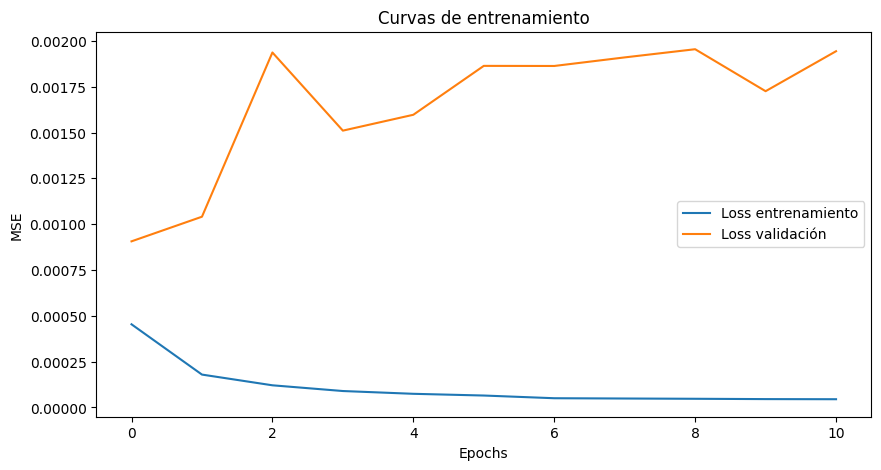

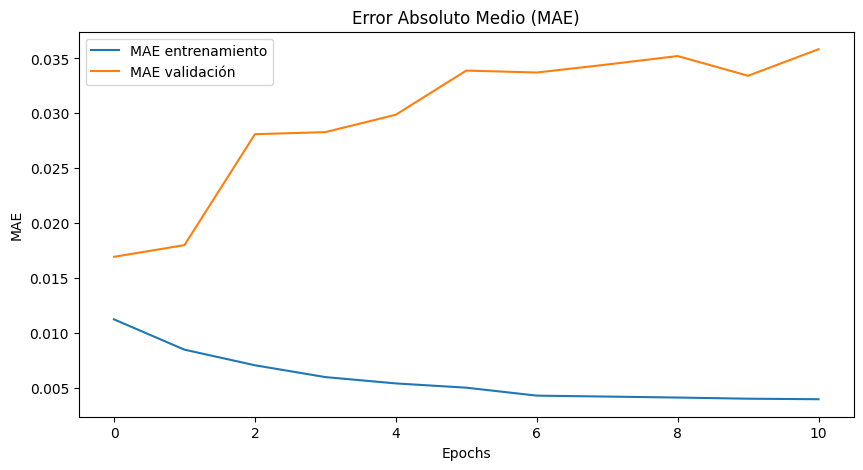

In [18]:
# =============================================
# Paso 4: Construcción y entrenamiento del modelo
# =============================================

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# ------------------------------
# 1. Definir el modelo
# ------------------------------
def build_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        # Bloque LSTM/GRU (mejor para secuencias)
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(64),
        layers.Dropout(0.2),

        # Capa densa final
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="linear")  # salida: precio normalizado
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="mse",
        metrics=["mae"]
    )
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

print(model.summary())

# ------------------------------
# 2. Callbacks para robustez
# ------------------------------
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

earlystop_cb = keras.callbacks.EarlyStopping(
    patience=10,          # espera 10 epochs sin mejora
    restore_best_weights=True,
    monitor="val_loss"
)

reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    factor=0.5,           # reduce LR a la mitad
    patience=5,
    min_lr=1e-6,
    monitor="val_loss"
)

# ------------------------------
# 3. Entrenamiento
# ------------------------------
EPOCHS = 100
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb],
    verbose=1
)

# ------------------------------
# 4. Guardar el modelo final
# ------------------------------
model.save("final_model.keras")
print("📦 Modelo final guardado como final_model.keras")

# ------------------------------
# 5. Visualización de métricas
# ------------------------------
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Loss entrenamiento")
plt.plot(history.history["val_loss"], label="Loss validación")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Curvas de entrenamiento")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history["mae"], label="MAE entrenamiento")
plt.plot(history.history["val_mae"], label="MAE validación")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Error Absoluto Medio (MAE)")
plt.legend()
plt.show()


PASO 05: INICIO PRUEBAS

In [33]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ===========================
# Paso 05: Testeo Global
# ===========================

ticker = "AMZN"   # seleccionamos APPLE para la demo

# 1) Recuperar los scalers correctos (X e y)
scaler_X, scaler_y = scalers[ticker]

# 2) Preparar datos (asegurarse de que tienes X_test, y_test de este ticker)
#    Nota: Si X_test está en 3D, NO se normaliza otra vez, ya estaba hecho.
y_pred = model.predict(X_test)

# 3) Desnormalizar
y_pred = scaler_y.inverse_transform(y_pred)
y_real = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# 4) Métricas (con protección contra división por cero)
mae = mean_absolute_error(y_real, y_pred)
rmse = mean_squared_error(y_real, y_pred) ** 0.5

mape = (np.abs((y_real - y_pred) / np.where(y_real == 0, 1, y_real)).mean() * 100)

print("===== Evaluación Global ({}): =====".format(ticker))
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

# ===========================
# Paso 06: Predicción puntual
# ===========================

# Tomemos la última secuencia de prueba
sample_X = X_test[-1:]   # última ventana
sample_y = y_test[-1:]   # último valor real (aún normalizado)

# Predicción
sample_pred = model.predict(sample_X)

# Desnormalizar
sample_pred = scaler_y.inverse_transform(sample_pred)
sample_real = scaler_y.inverse_transform(sample_y.reshape(-1, 1))

print("\n===== Predicción puntual ({}) =====".format(ticker))
print(f"Predicción IA : {sample_pred[0][0]:.2f}")
print(f"Valor Real    : {sample_real[0][0]:.2f}")


524/524 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
===== Evaluación Global (AMZN): =====
MAE : 4.0960
RMSE: 7.2857
MAPE: 26.38%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

===== Predicción puntual (AMZN) =====
Predicción IA : 79.35
Valor Real    : 78.90


PASO 06: Descarga del modelo entrenado

In [21]:
# ------------------------------
# 📦 Paso 06: Guardar modelo y scaler
# ------------------------------

import joblib

# Guardar el modelo entrenado en formato estándar Keras
model.save("final_model.keras")
print("✅ Modelo guardado como final_model.keras")

# Guardar los scalers (para normalizar los datos en predicciones futuras)
joblib.dump(scalers, "scalers.pkl")
print("✅ Scalers guardados como scalers.pkl")

# (Opcional) Guardar en formato HDF5 (.h5), útil si quieres cargar en frameworks antiguos
model.save("final_model.h5")
print("✅ Modelo adicional guardado como final_model.h5")


✅ Modelo guardado como final_model.keras
✅ Scalers guardados como scalers.pkl
✅ Modelo adicional guardado como final_model.h5


PASO 06: DESCARGAR EL MODELO ENTRENADO EN LAS DESCARGAS

In [22]:
from google.colab import files
files.download("final_model.keras")
files.download("scalers.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>